# Pixel-based Decoding

Original tutorial extracted from: 

https://spacetx-starfish.readthedocs.io/en/mcai-api-additions/gallery/tutorials/pixelbased_decoding.html#sphx-glr-gallery-tutorials-pixelbased-decoding-py

100%|██████████| 2437/2437 [00:00<00:00, 51988.01it/s]


The area of the first spot is 7


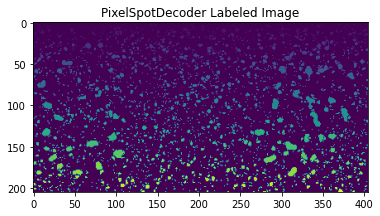

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from starfish import data, FieldOfView, display
from starfish.image import Filter
from starfish.spots import DetectPixels
from starfish.types import Axes, Features, Levels

# Load MERFISH data
experiment = data.MERFISH(use_test_data=True)
imgs = experiment.fov().get_image(FieldOfView.PRIMARY_IMAGES)

# filter and deconvolve data
ghp = Filter.GaussianHighPass(sigma=3)
dpsf = Filter.DeconvolvePSF(num_iter=15, sigma=2, level_method=Levels.SCALE_SATURATED_BY_CHUNK)
glp = Filter.GaussianLowPass(sigma=1)
ghp.run(imgs, in_place=True)
dpsf.run(imgs, in_place=True)
glp.run(imgs, in_place=True)

# scale data with user-defined factors to normalize images. For this data set, the scale factors
# are stored in experiment.json.
scale_factors = {
    (t[Axes.ROUND], t[Axes.CH]): t['scale_factor']
    for t in experiment.extras['scale_factors']
}
filtered_imgs = deepcopy(imgs)
for selector in imgs._iter_axes():
    data = filtered_imgs.get_slice(selector)[0]
    scaled = data / scale_factors[selector[Axes.ROUND.value], selector[Axes.CH.value]]
    filtered_imgs.set_slice(selector, scaled, [Axes.ZPLANE])

# Decode with PixelSpotDecoder
psd = DetectPixels.PixelSpotDecoder(
    codebook=experiment.codebook,
    metric='euclidean',             # distance metric to use for computing distance between a pixel vector and a codeword
    norm_order=2,                   # the L_n norm is taken of each pixel vector and codeword before computing the distance. this is n
    distance_threshold=0.5176,      # minimum distance between a pixel vector and a codeword for it to be called as a gene
    magnitude_threshold=1.77e-5,    # discard any pixel vectors below this magnitude
    min_area=2,                     # do not call a 'spot' if it's area is below this threshold (measured in pixels)
    max_area=np.inf,                # do not call a 'spot' if it's area is above this threshold (measured in pixels)
)
initial_spot_intensities, prop_results = psd.run(filtered_imgs)

# filter spots that do not pass thresholds
spot_intensities = initial_spot_intensities.loc[initial_spot_intensities[Features.PASSES_THRESHOLDS]]

# Example of how to access the spot attributes
print(f"The area of the first spot is {prop_results.region_properties[0].area}")

# View labeled image after connected componenet analysis
plt.imshow(prop_results.label_image[0])
plt.title("PixelSpotDecoder Labeled Image")

# View decoded spots overlaid on max intensity projected image
single_plane_max = filtered_imgs.reduce({Axes.ROUND, Axes.CH, Axes.ZPLANE}, func="max")

## Show in TissUUmaps 

Prepare the experiment to be compatible with the TissUUmaps "Spot Inspector" plugin

In [2]:
import starfish2tmap

csv_name = starfish2tmap.qc_csv(experiment=experiment,
                     spot_intensities=spot_intensities,
                     output_name="pixel_decoding.csv")

image_names = starfish2tmap.qc_images(filtered_imgs=filtered_imgs)

In [3]:
import tissuumaps.jupyter as tmap

tmap.loaddata(images=image_names, 
              csvFiles=csv_name, 
              xSelector="x", ySelector="y", keySelector='target_name',   
              port=5001,
              plugins=['Spot_Inspector'])

INFO:root: * TissUUmaps version: 3.0.9.4



Creating project file c:\Users\educh799\Documents\Research\tissuumaps_tutorials\tissuumaps_starfish\MERFISH\_project.tmap
Loading url:  http://localhost:5001/_project.tmap?path=Users\educh799\Documents\Research\tissuumaps_tutorials\tissuumaps_starfish\MERFISH
